<a href="https://colab.research.google.com/github/sravanjosh07/Behavioural_cloning/blob/main/Behavioural_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sravanjosh07/Track


fatal: destination path 'Track' already exists and is not an empty directory.


In [ ]:
!ls Track

driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Flatten, Dropout, MaxPool2D, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath

In [ ]:
datadir = 'Track'
columns = ['centre',  'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,/Users/Sravan/Desktop/Data/IMG/center_2021_07_25_18_53_59_930.jpg,/Users/Sravan/Desktop/Data/IMG/left_2021_07_25_18_53_59_930.jpg,/Users/Sravan/Desktop/Data/IMG/right_2021_07_25_18_53_59_930.jpg,0.0,0.0,0,0.000047
1,/Users/Sravan/Desktop/Data/IMG/center_2021_07_25_18_54_00_032.jpg,/Users/Sravan/Desktop/Data/IMG/left_2021_07_25_18_54_00_032.jpg,/Users/Sravan/Desktop/Data/IMG/right_2021_07_25_18_54_00_032.jpg,0.0,0.0,0,0.000048
2,/Users/Sravan/Desktop/Data/IMG/center_2021_07_25_18_54_00_136.jpg,/Users/Sravan/Desktop/Data/IMG/left_2021_07_25_18_54_00_136.jpg,/Users/Sravan/Desktop/Data/IMG/right_2021_07_25_18_54_00_136.jpg,0.0,0.0,0,0.000047
3,/Users/Sravan/Desktop/Data/IMG/center_2021_07_25_18_54_00_242.jpg,/Users/Sravan/Desktop/Data/IMG/left_2021_07_25_18_54_00_242.jpg,/Users/Sravan/Desktop/Data/IMG/right_2021_07_25_18_54_00_242.jpg,0.0,0.0,0,0.000048
4,/Users/Sravan/Desktop/Data/IMG/center_2021_07_25_18_54_00_346.jpg,/Users/Sravan/Desktop/Data/IMG/left_2021_07_25_18_54_00_346.jpg,/Users/Sravan/Desktop/Data/IMG/right_2021_07_25_18_54_00_346.jpg,0.0,0.0,0,0.000048


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['centre'] = data['centre'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)


In [ ]:
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,center_2021_07_25_18_53_59_930.jpg,left_2021_07_25_18_53_59_930.jpg,right_2021_07_25_18_53_59_930.jpg,0.0,0.0,0,0.000047
1,center_2021_07_25_18_54_00_032.jpg,left_2021_07_25_18_54_00_032.jpg,right_2021_07_25_18_54_00_032.jpg,0.0,0.0,0,0.000048
2,center_2021_07_25_18_54_00_136.jpg,left_2021_07_25_18_54_00_136.jpg,right_2021_07_25_18_54_00_136.jpg,0.0,0.0,0,0.000047
3,center_2021_07_25_18_54_00_242.jpg,left_2021_07_25_18_54_00_242.jpg,right_2021_07_25_18_54_00_242.jpg,0.0,0.0,0,0.000048
4,center_2021_07_25_18_54_00_346.jpg,left_2021_07_25_18_54_00_346.jpg,right_2021_07_25_18_54_00_346.jpg,0.0,0.0,0,0.000048


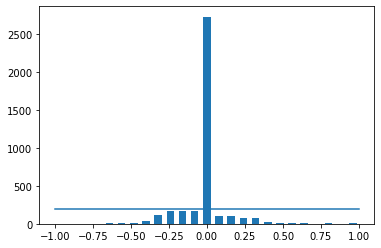

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)

center = (bins[:-1] + bins[1:])/2
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin) )

 now it has more data with 0 steering angle and hence we are only considering 200 instances of a particular value, that way the model would not show bias over a specific steering angle. So rejecting all values after a certain threshold. 

total data : 3809
removed_list: 2531
remaining data: 1278


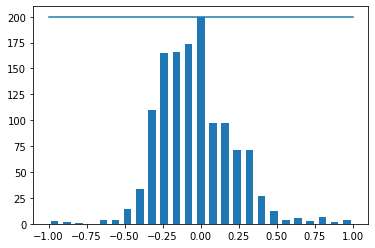

In [ ]:
print("total data :", len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed_list:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin) )



In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering =[]
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir +'/IMG', data)


centre      center_2021_07_25_18_54_00_865.jpg
left          left_2021_07_25_18_54_00_865.jpg
right        right_2021_07_25_18_54_00_865.jpg
steering                            -0.0416039
throttle                             0.0141149
reverse                                      0
speed                                0.0117094
Name: 9, dtype: object


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('training samples: {} \n Validation samples : {}' .format(len(X_train), len(X_val)))

training samples: 1022 
 Validation samples : 256


Text(0.5, 1.0, 'Training Set')

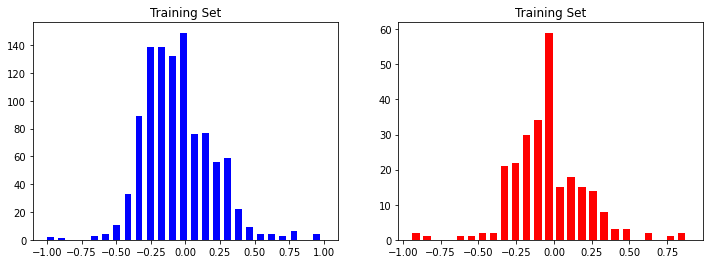

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
axes[0].hist(y_train, bins =num_bins, width = 0.05, color = 'blue')
axes[0].set_title("Training Set")
axes[1].hist(y_val, bins =num_bins, width = 0.05, color = 'red')
axes[1].set_title("Training Set")


In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[ 60:135,: ,: ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed_Img')

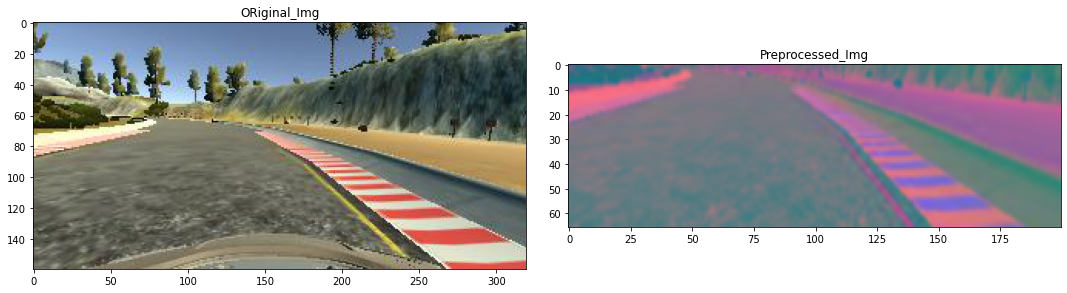

In [ ]:
image = image_paths[300]
original_img = mpimg.imread(image)
preprocessed_img = img_preprocess(image)
fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_img)
axes[0].set_title("ORiginal_Img")
axes[1].imshow(preprocessed_img)
axes[1].set_title("Preprocessed_Img")



In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(1022, 66, 200, 3)


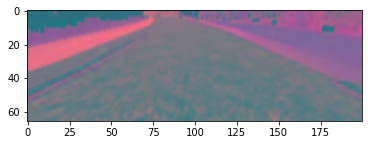

In [ ]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
print(X_train.shape)

In [ ]:
def nvidia_model():
 
  model = Sequential()
 
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
 
 
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
 
 
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
 
 
  optimizer= Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)            

In [ ]:
history = model.fit(X_train, y_train, epochs= 30, validation_data= (X_val, y_val), batch_size= 100, verbose = 1, shuffle=1)

Epoch 1/30
11/11 [==============================] - 8s 584ms/step - loss: 0.6441 - val_loss: 0.0658
Epoch 2/30
11/11 [==============================] - 6s 530ms/step - loss: 0.0757 - val_loss: 0.0589
Epoch 3/30
11/11 [==============================] - 6s 528ms/step - loss: 0.0628 - val_loss: 0.0585
Epoch 4/30
11/11 [==============================] - 6s 533ms/step - loss: 0.0621 - val_loss: 0.0587
Epoch 5/30
11/11 [==============================] - 6s 531ms/step - loss: 0.0644 - val_loss: 0.0589
Epoch 6/30
11/11 [==============================] - 6s 535ms/step - loss: 0.0709 - val_loss: 0.0584
Epoch 7/30
11/11 [==============================] - 6s 533ms/step - loss: 0.0646 - val_loss: 0.0586
Epoch 8/30
11/11 [==============================] - 6s 530ms/step - loss: 0.0625 - val_loss: 0.0585
Epoch 9/30
11/11 [==============================] - 6s 529ms/step - loss: 0.0650 - val_loss: 0.0584
Epoch 10/30
11/11 [==============================] - 6s 530ms/step - loss: 0.0628 - val_loss: 0.0583

Text(0.5, 0, 'Epochs')

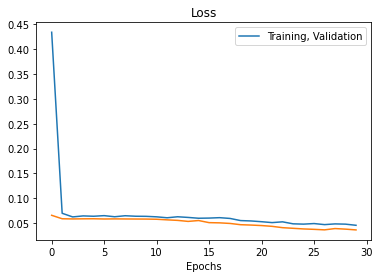

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training, Validation'])
plt.title("Loss")
plt.xlabel('Epochs')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')